In [43]:
import numpy as np
import sys
from statsmodels.tsa.arima.model import ARIMA 
import matplotlib.pyplot as plt
sys.path.append('../')

from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder

## Implementing the MCMC procedure as proposed by Andreini 
We consider the model
$$
\mathbf{\mathbb{f}}_t = G(\mathbf{y}_t) \\ 
\mathbf{y}_t = F(\mathbf{\mathbb{f}}_t) + \mathbf{\varepsilon}_t \\ 
\mathbf{\mathbb{f}}_t = \mathbf{B}_1 \mathbf{f}_{t-1} + \cdots + \mathbf{B}_p \mathbf{f}_{t-p} + \mathbf{u}_t \\
\mathbf{\varepsilon}_t = \mathbf{\Phi_1} \mathbf{\varepsilon}_{t-1} + \cdots \mathbf{\Phi_d} \mathbf{\varepsilon}_{t-d} + \mathbf{\epsilon}_t 
$$


In [56]:
class ArProcess():
    """
    class containing the autoregressive processes of the idiosyncratic error terms \varepsilon_t
    This should be a var process if Q can be nondiagonal
    """
    def __init__(self, n:int, T:int,d:int):
        self.n = n
        self.T = T 
        self.d = d #number of lags
        self.models = None
        self.parameters = None

    def fit(self, x):
        self.models = [ARIMA(order=(self.d,0,0), trend='n', endog=x[i,:]) for i in range(x.shape[0])]
        self.fitted = [mod.fit() for mod in self.models]

    def conditionalExpectation(self):
        """
        obtain Phi(L)eps_t
        """
        return np.vstack([mod.predict() for mod in self.fitted])
    
    def simulate(self):
        return np.vstack([mod.simulate(nsimulations=self.T) for mod in self.fitted])

In [57]:
n = 10
T = 100
eps = np.random.normal(size = (n,T))
print(eps.shape)
ar = ArProcess(n,T,1)
ar.fit(eps)
pred = ar.conditionalExpectation()
pred.shape
sim = ar.simulate()
sim.shape

(10, 100)


(10, 100)

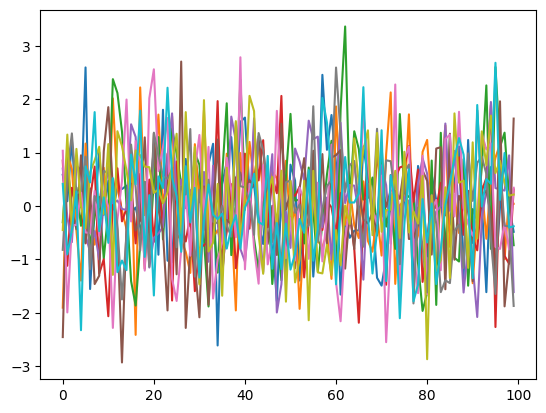

In [58]:
#plt.plot(eps.T);
plt.plot(sim.T);

In [ ]:
def init_eps(n,T):
    """
    Initinitalize idiosyncratic error terms.
    """
    #TODO: How to do this lol?
    return np.random.normal(size = (n,T))

def d2FMMCMC(y: np.ndarray, autoEncoder: AutoEncoder):
    n = y.shape[0]
    eps = init_eps()
    phi = ArProcess(n,T,d=1).fit(eps)
    while not convergence:
        y_tilde = y - phi.conditionalExpectation()
        for epoch in range(n_epoch):
            y_tilde_mc = y_tilde+phi.simulate()
            
            
        
